# Multivariate time series forecasting with Vector Auto Regression (VAR)


## Description

This notebook will use soil moisture, retrieved from the Global Rootzone moisture Analysis and Forecasting System (GRAFS), to make a short-term forecast of vegetation condition (using NDVI). GRAFS is produced by the [ANU Centre for Water and Landscape Dynamics](http://wald.anu.edu.au/). The model estimates the surface (0-5 cm) and root-zone (0-1 m) soil moisture at 10 km spatial resolution globally, using the precipitation measured by the Global Precipitation Measurement (GPM) mission and through assimilation of the soil moisture product from the Soil Moisture Active/Passive (SMAP) mission.

This product is regularly updated and made available through National Computational Infrastructure’s open access THREDDS data server.


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datacube import Datacube

from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from load_era5 import load_era5

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import grangercausalitytests

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46193 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


## Analysis parameters

* `lat`, `lon`: The central latitude and longitude to analyse e.g. 14.283, -16.921
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower
* `time_range`: The date range to analyse e.g. ('2013', '2020')
* `freq`: The frequency we want to resample the time-series to e.g. for monthly time steps use `'1M'`, for fortinightly use `'2W'`
* `forecast_length`: The number of time-steps (in units of the resampling frequency) to forecast. The longer the forecast, the less accurate the forecast will be. A forecast of vegetation condition will most likley not be accurate beyone 3-4 months.
* `dask_chunks`: How to chunk the datasets to work with dask

In [7]:
# Define the analysis region (Lat-Lon box)
lat, lon = -17.8137, 125.3615 # native grasslandin Pilbara
buffer = 0.02

products = "ga_ls7e_ard_3", "ga_ls8c_ard_3"

# Define the time window
time_range = ('2015-01-01', '2020-12-30')

#resample frequency
freq='1M'

#length of forecast (in units of resample frequency)
forecast_length = 2

#dask chunk sizes
dask_chunks={'x':-1, 'y':-1, 'time':-1}

## Display analysis area on an interactive map

In [6]:
lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

display_map(lon,lat)

## Retrieve multiple environmental datasets

### Load the satellite data

In [ ]:
# connect to the datacube
dc = Datacube(app='VAR-forecast')

# set up a datcube query object
query = {'x': lon, 'y': lat,
         'time': time_range,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

In [8]:
# load the satellite data
ds = load_ard(dc=dc, 
              dask_chunks=dask_chunks,
              products=products,
              **query)


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 657 time steps as a dask array


#### Calculate NDVI time-series

The satellite data will be computed here so this cell with take a few minutes to run

In [9]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_ls_3')

#interpolate NDVI to a monthly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time=freq).mean()
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

Dropping bands ['nbart_red', 'nbart_nir']


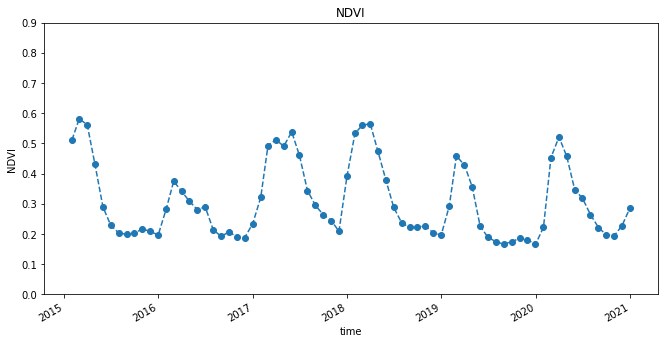

In [10]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.title('NDVI')
plt.ylim(0,0.9);

### Retrieval of surface and root-zone wetness

> `Surface wetness` is measured relative to wettest condition recorded for a location.

> `Rootzone Soil Water Index` is derived from surface relative wetness

In [11]:
# function to load soil moisture data
def load_soil_moisture(lat, lon, time, grid=None, product = 'surface'):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # define a grid that covers the entire area of interest
    lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05),
                          np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
    lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05),
                          np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'GRAFS_TopSoilRelativeWetness_'
    else: product_name = 'GRAFS_RootzoneSoilWaterIndex_'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)

# Retrieve surface soil moisture using query parameters
surface_wetness = load_soil_moisture(lat, lon, time) #grid='nearest'

# retrieve rootzone soil moisture using query parameters
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone') #grid='nearest'

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2015.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2016.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2019.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2020.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2015.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2016.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRA

### Convert all datasets to 1D time-series

And resample to common time-step

In [12]:
# zonal mean
surface_wetness=surface_wetness.relative_wetness.mean(['lat','lon'])
rootzone_wetness=rootzone_wetness.soil_water_index.mean(['lat','lon'])

#resample using monthly means
surface_wetness=surface_wetness.resample(time=freq).mean()
rootzone_wetness=rootzone_wetness.resample(time=freq).mean()

### Plot all datasets together

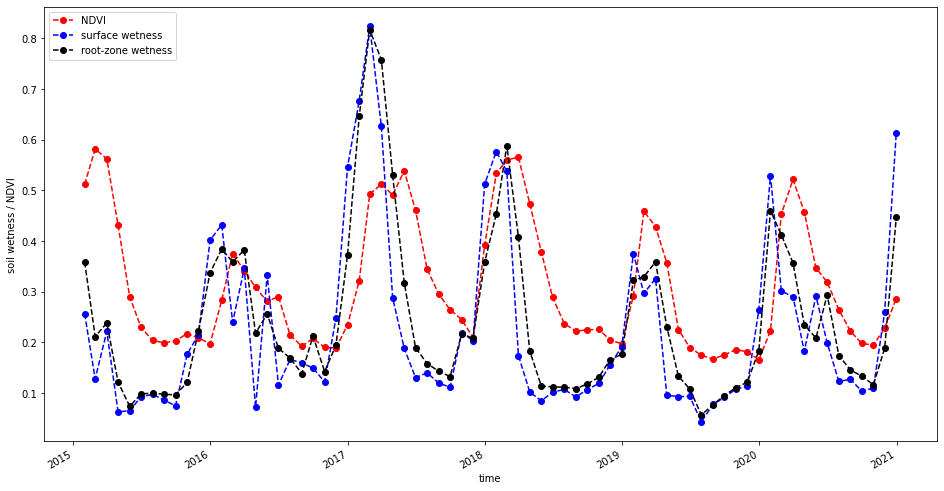

In [14]:
# plot soil moisture with precipitation
fig, ax1 = plt.subplots(figsize=(16,8))
ndvi.plot(ax=ax1,label='NDVI',color='red',linestyle='dashed', marker='o')
surface_wetness.plot(ax = ax1,label='surface wetness',color='blue',linestyle='dashed', marker='o')
rootzone_wetness.plot(ax = ax1,label='root-zone wetness',color='black',linestyle='dashed', marker='o')
ax1.set_ylabel('soil wetness / NDVI')
ax1.legend(loc='upper left');

### Convert datasets to a pandas dataframes

In [15]:
#convert to dfs
ndvi=ndvi.drop('spatial_ref').to_dataframe()
surface_wetness=surface_wetness.to_dataframe()
rootzone_wetness=rootzone_wetness.to_dataframe()

#add other variables to ndvi
ndvi['surface_wetness']=surface_wetness['relative_wetness']
ndvi['rootzone_wetness']=rootzone_wetness['soil_water_index']

#drop an rows with nans
ndvi = ndvi.dropna()
ndvi.head()

,NDVI,surface_wetness,rootzone_wetness
time,,,
2015-01-31,0.511657,0.256306,0.358524
2015-02-28,0.581514,0.127813,0.211244
2015-03-31,0.562113,0.221275,0.237979
2015-04-30,0.430937,0.062596,0.121340
2015-05-31,0.289555,0.064776,0.073383


## Convert to standardised anomalies?

## Test causation

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.
Below, we conduct a [Granger's Causality Test](https://en.wikipedia.org/wiki/Granger_causality) to see if the variables are related to each other.  In the table that's printed after running the two cells belows shows a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

In [16]:
def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [17]:
grangers_causation_matrix(ndvi, variables = ndvi.columns)  

,NDVI_x,surface_wetness_x,rootzone_wetness_x
NDVI_y,1.0000,0.0,0.0000
surface_wetness_y,0.0008,1.0,0.0013
rootzone_wetness_y,0.0000,0.0,1.0000


## Test for stationarity 

VAR models require the time series you want to forecast to be stationary. A stationary time series is one whose characteristics like mean and variance does not change over time. 
To test the stationarity, we can use a method called the [Augmented Dickey-Fuller Test (ADF Test)](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/).

If the time-series are non-stationary, you can make it stationary by differencing the series once and repeating the test again until it becomes stationary. Differencing can be done easily using the following code snippet:

    df_differenced = df_train.diff().dropna()

Define a function for conducting an ADF test

In [29]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    ADF Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data is non-Stationary.')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Should not reject the Null Hypothesis")
        print(f" => Series is Non-Stationary.")    

In [19]:
# ADF Test on each column
for name, column in ndvi.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    ADF Test on "NDVI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.3303. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    ADF Test on "surface_wetness" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.4979. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    ADF Test on "rootzone_wetness" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




## Conduct iterative back-test to validate forecasting ability

Here we will conduct a forecast, but over an interval of the time-series that we already have observations for. This will allow us to test the model's forecasting ability 

First, lets initiate a model

In [20]:
model=VAR(ndvi, freq=freq)

### Find the best lag order using Akaike information criterion (AIC)


Lag order to use is 2


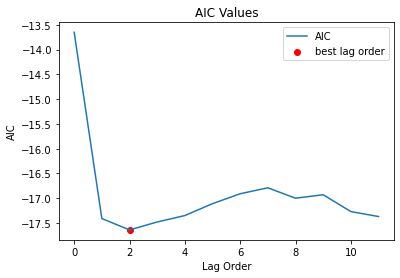

In [21]:
#calculate AIC
x=model.select_order()

#convert to pandas df
aic=pd.read_html(x.summary().as_html(),header=0, index_col=0)[0][['AIC']]
aic['AIC']=[float(i[0:6]) for i in aic.values.flatten()]

#find the first minimum in the series (not the lowest AIC but the first, lowest AIC)
asign=np.sign(aic.diff()) #first derivative
signchange = ((np.roll(asign, 1) - asign) != 0).astype(int) #where does the sign change?
lag_order=np.nonzero(~signchange.astype(bool).AIC.values)[0][0] #find first sign change

#plot
aic.plot()
plt.scatter(lag_order, aic.loc[lag_order], color='r', label='best lag order')
plt.title('AIC Values')
plt.ylabel('AIC')
plt.xlabel('Lag Order')
plt.legend()
print("Lag order to use is "+str(lag_order))

### Create and fit a model on the data

Using the lag order defined above

In [22]:
model=VAR(ndvi, freq=freq)
model_fit = model.fit(lag_order)

### Iteratively loop through the window size (for n number of windows) and forecast 

In [23]:
n_windows = int((len(ndvi) / forecast_length) - 1)
window_size = forecast_length

aa = window_size
dfs=[]
for i in range(0, n_windows):
    start=aa+lag_order
    end=(aa)
    backtest_input = ndvi.values[-start:-end] 
    fc = model_fit.forecast(y=backtest_input, steps=window_size)  
    if i == 0:
        index=ndvi.index[-end:]
    else:
        index=ndvi.index[-end:-(end-window_size)]
    fc = pd.DataFrame(fc, index=index, columns=ndvi.columns)
    dfs.append(fc)
    aa+=window_size                       

#concat results together
fc=pd.concat(dfs)

### Check RMSE of each variable

In [24]:
test=ndvi[ndvi.index.isin(fc.index)]
for i in test.columns:
    print('rmse value for', i, 'is : ', round(rmse(fc[[i]], test[[i]])[0],2))

rmse value for NDVI is :  0.17
rmse value for surface_wetness is :  0.18
rmse value for rootzone_wetness is :  0.18


### Plot the results of the back test

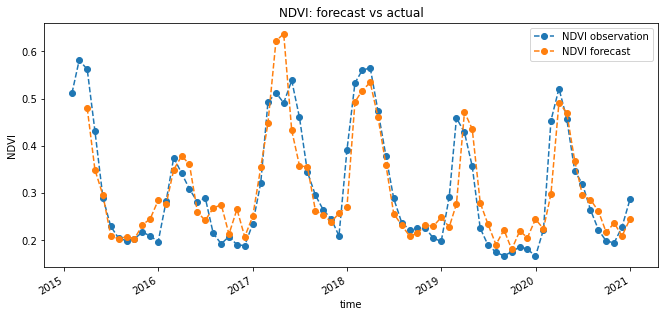

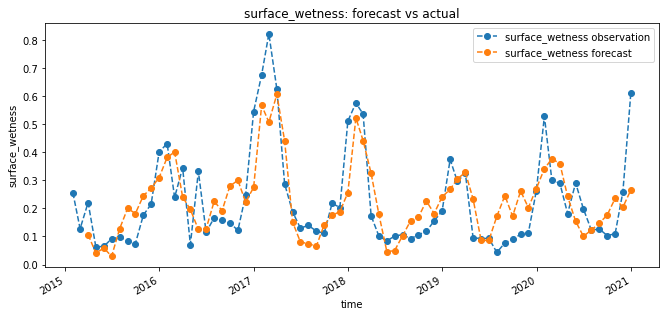

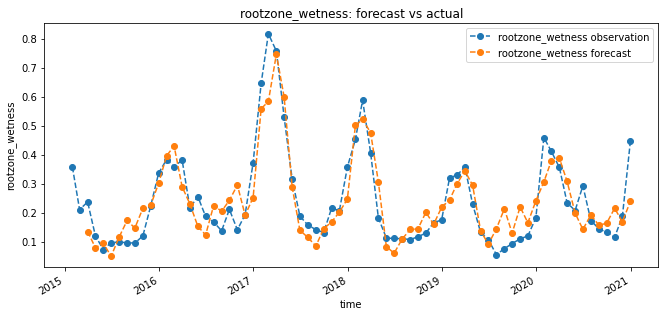

In [25]:
for col in ndvi.columns:
    plt.figure(figsize=(11,5))
    plt.plot(ndvi.index, ndvi[col], label=col+' observation',linestyle='dashed', marker='o')
    fc[col].plot(label=col+' forecast',linestyle='dashed', marker='o')
    plt.ylabel(col)
    plt.title(col+": forecast vs actual")
    plt.legend();

## Forecasting

In [26]:
#make final predictions
model = VAR(endog=ndvi,freq=freq)
model_fit = model.fit(lag_order)

pred = model_fit.forecast(ndvi.values[-model_fit.k_ar:], steps=forecast_length)

In [27]:
#converting predictions to dataframe
cols = ndvi.columns
fc = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        fc.iloc[i][j] = pred[i][j]

fc.index = pd.date_range(freq=freq, start=ndvi.index[-1], periods=len(fc)+1)[1:]
fc.head()

,NDVI,surface_wetness,rootzone_wetness
2021-01-31,0.40312,0.545983,0.572377
2021-02-28,0.472857,0.48838,0.575778


### Plot the result of our forecast

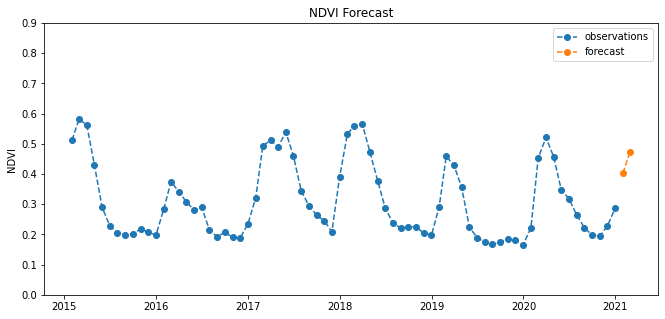

In [28]:
plt.figure(figsize=(11,5))
plt.plot(ndvi.index, ndvi['NDVI'], label='observations',linestyle='dashed', marker='o')
plt.plot(fc.index, fc[['NDVI']], label='forecast',linestyle='dashed', marker='o')
plt.ylabel('NDVI')
plt.title("NDVI Forecast")
plt.ylim(0.0,0.9)
plt.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 